In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 22.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import optuna

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
train_data.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


<ipython-input-17-07763f6b15c4>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Defecte', data=melted_data_present, palette=pink_palette)
<ipython-input-17-07763f6b15c4>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)


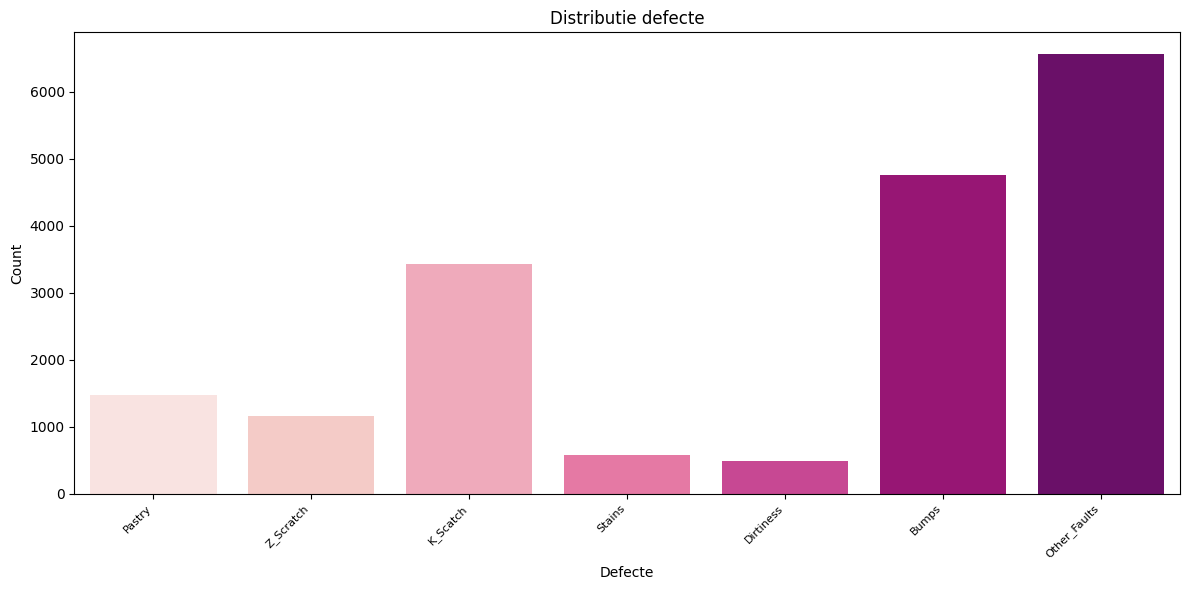

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target_data = train_data[target_columns]

melted_data = target_data.melt(var_name='Defecte', value_name='Presence')
melted_data_present = melted_data[melted_data['Presence'] == 1]

pink_palette = sns.color_palette("RdPu", n_colors=len(target_columns))

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Defecte', data=melted_data_present, palette=pink_palette)

plt.title('Distributie defecte')
plt.xlabel('Defecte')
plt.ylabel('Count')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()


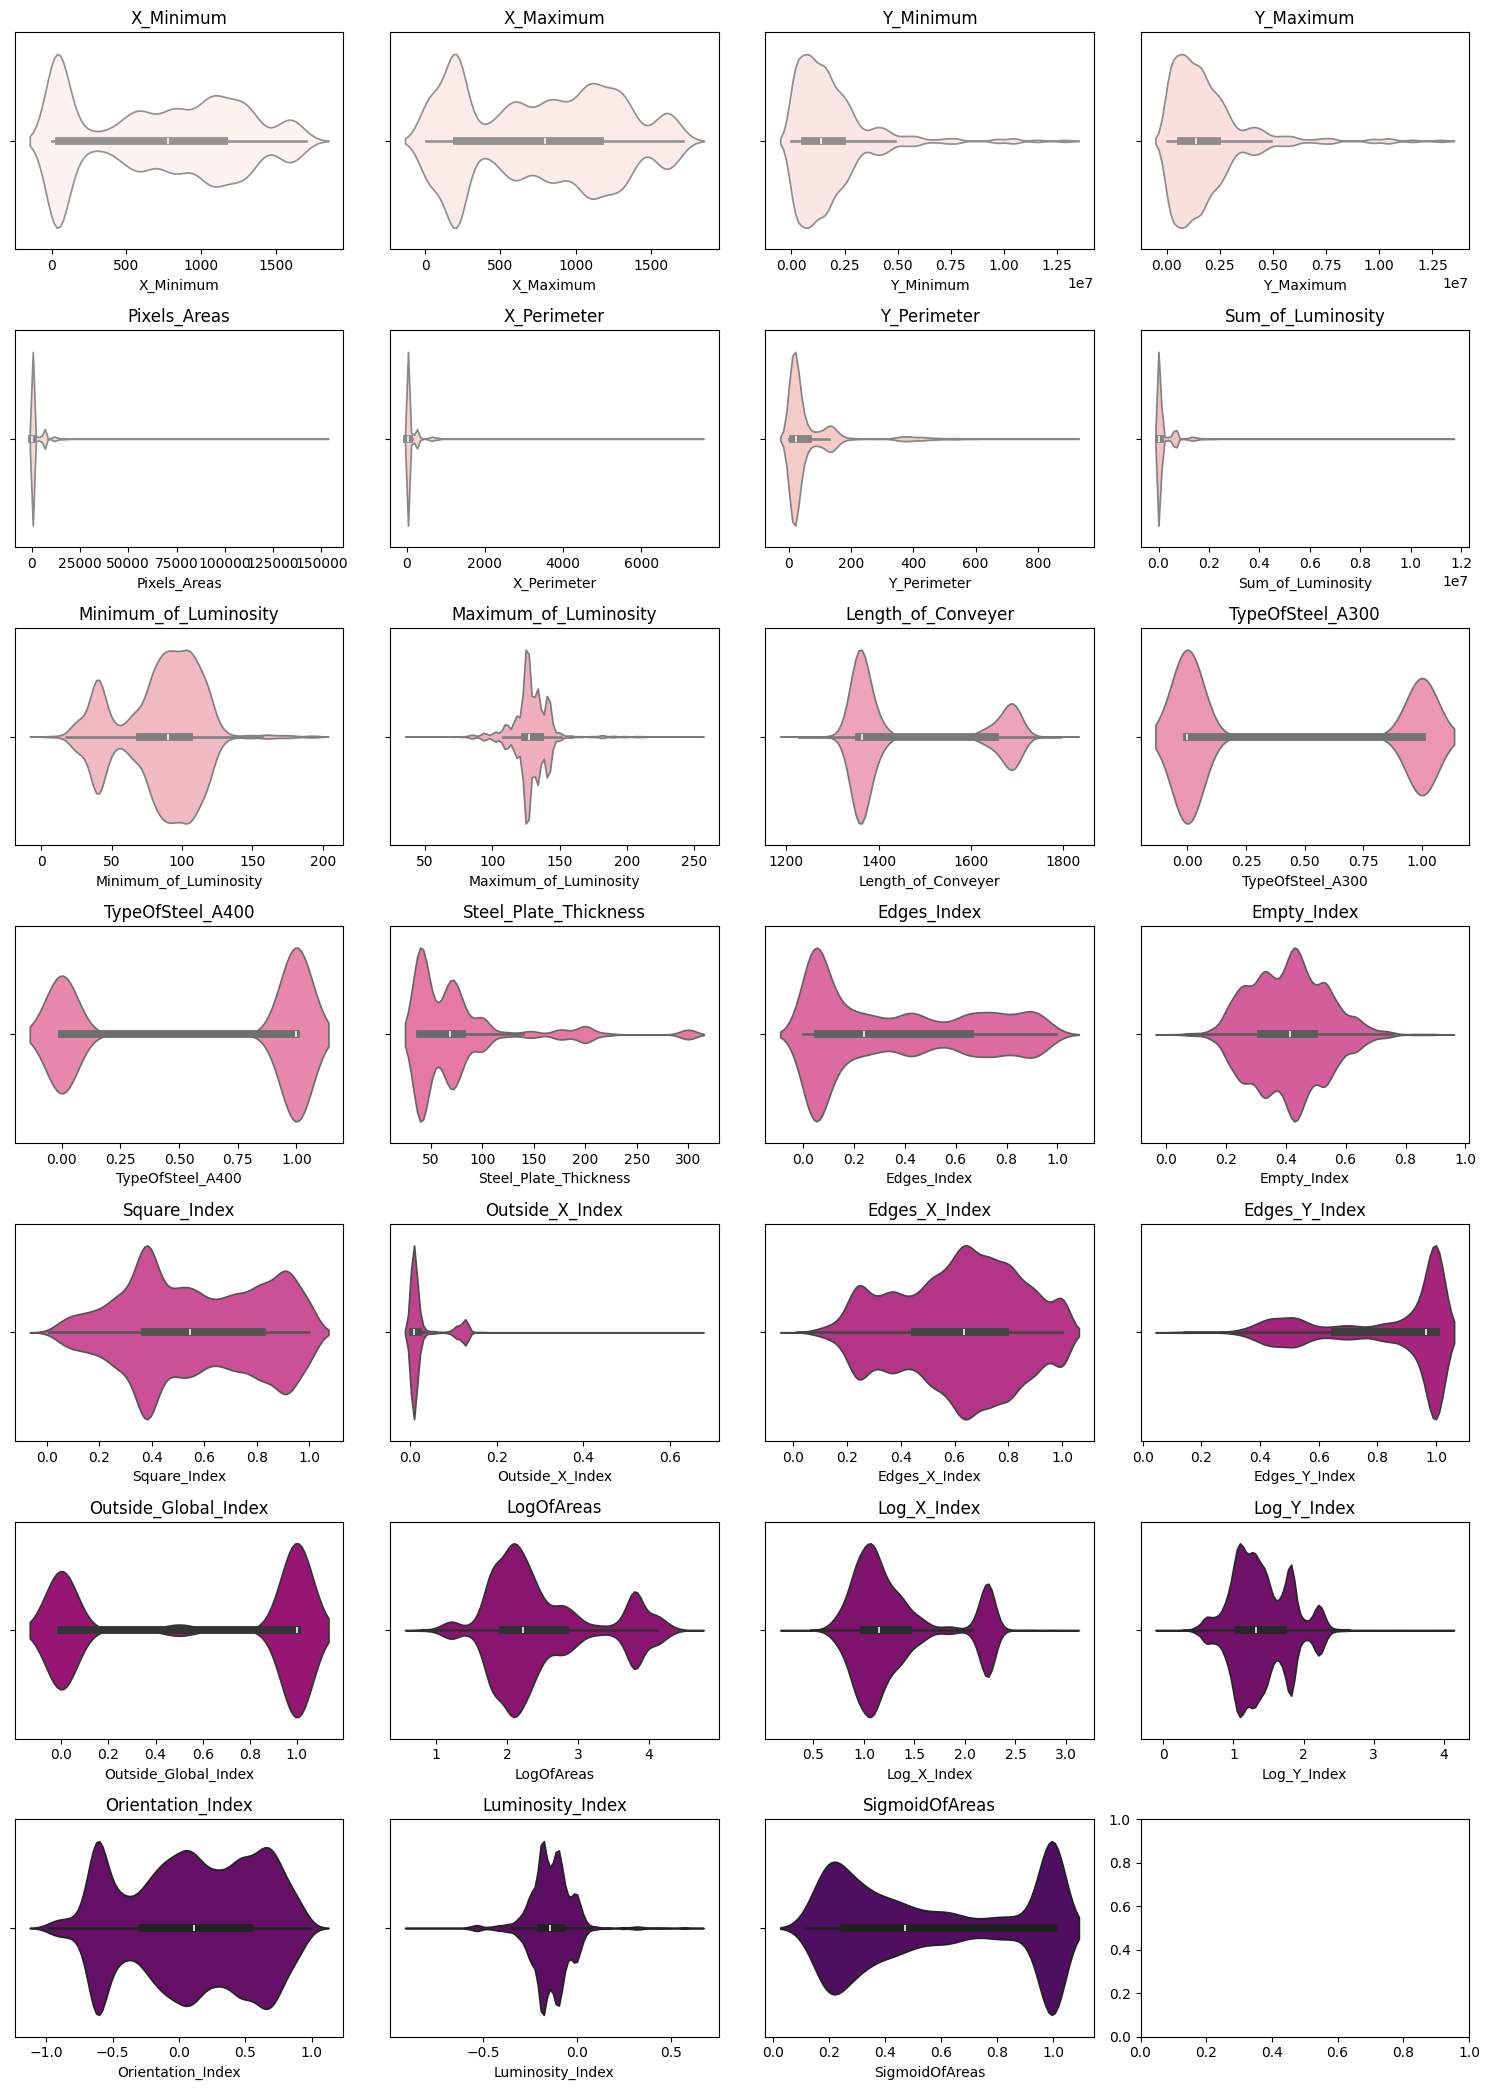

In [ ]:
feature_columns = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
                   'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity',
                   'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300',
                   'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index',
                   'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index',
                   'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index',
                   'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas']

num_features = len(feature_columns)
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

pink_palette = sns.color_palette("RdPu", n_colors=num_features)

for i, column in enumerate(feature_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    sns.violinplot(x=train_data[column], ax=axes[row_idx, col_idx], color=pink_palette[i])
    axes[row_idx, col_idx].set_title(column)

plt.tight_layout()
plt.show()

In [ ]:
for df in [train_data, test_data]:
    df['Luminosity_Range'] = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity']
    df['Normalized_Luminosity'] = df['Sum_of_Luminosity'] / df['Pixels_Areas']

X = train_data.drop(['id','Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis=1)
y = train_data[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]
X_test = test_data.drop('id', axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [ ]:
base_models = [
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=100,
        learning_rate=0.08,
        max_depth=3,
        random_state=42
    )),
    ('catboost', CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=6,
        random_state=42,
        verbose=0
    )),
    ('lgbm', LGBMClassifier(
        n_estimators=100,
        learning_rate=0.08,
        num_leaves=32,
        max_depth=8,
        random_state=42
    ))
]

In [ ]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

def objective(trial):
    weights = [trial.suggest_float(f'weight_{i}', 0.0, 1.0) for i in range(len(base_models))]
    weights = [w / sum(weights) for w in weights]

    cv_scores = []
    for train_index, val_index in kf.split(X_scaled):
        X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]


        fold_scores = []
        for i in range(y.shape[1]):
            estimators = [(name, model) for name, model in base_models]
            voting_clf = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
            voting_clf.fit(X_train_fold, y_train_fold.iloc[:, i])

            y_val_pred = voting_clf.predict_proba(X_val_fold)[:, 1]
            roc_auc = roc_auc_score(y_val_fold.iloc[:, i], y_val_pred)
            fold_scores.append(roc_auc)

        cv_scores.append(np.mean(fold_scores))

    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_weights = study.best_params.values()
best_weights = [w / sum(best_weights) for w in best_weights]

estimators = [(name, model) for name, model in base_models]
voting_clf = VotingClassifier(estimators=estimators, voting='soft', weights=best_weights)

[I 2024-08-26 19:25:56,491] A new study created in memory with name: no-name-2623e275-e498-488c-8820-debcba018fde


[LightGBM] [Info] Number of positive: 1165, number of negative: 14210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6097
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075772 -> initscore=-2.501225
[LightGBM] [Info] Start training from score -2.501225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 930, number of negative: 14445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6097
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060488 -> initscore=-2.7

In [ ]:
voting_clfs = []
for i in range(y.shape[1]):
    estimators = [(name, model) for name, model in base_models]
    voting_clf = VotingClassifier(estimators=estimators, voting='soft', weights=best_weights)
    voting_clf.fit(X_scaled, y.iloc[:, i])
    voting_clfs.append(voting_clf)


test_pred = np.zeros((X_test.shape[0], y.shape[1]))
for i, voting_clf in enumerate(voting_clfs):
    test_pred[:, i] = voting_clf.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame(test_pred, columns=y.columns)
submission.insert(0, 'id', test_data['id'])
submission.to_csv('submission.csv', index=False)

[LightGBM] [Info] Number of positive: 1466, number of negative: 17753
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6122
[LightGBM] [Info] Number of data points in the train set: 19219, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.076279 -> initscore=-2.494017
[LightGBM] [Info] Start training from score -2.494017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1150, number of negative: 18069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6122
[LightGBM] [Info] Number of data points in the train set: 19219, number of used features: 3

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>